In [141]:
#################################################################################################
# fiveguys_2a.ipynb
# Team C: Five Guys: Burgers and Fries
# Aditya Jain, Alex Sandoval, Darrell Harvey, and Fasih Ahsan
# COM SCI X 450.1 Section 362062
# UCLA Extension, Spring 2018
# IPython Notebook for Class Project 2b Submission
# Script creates an EmotiFind function predictEmotion()
# Function input is a UTF-8 .txt file for any article, tweet, etc. Must be in the same folder as this .ipynb. 
# Function output is standard stream print of predicted emotion values for 8 emotions
# Sadness, Anger, Joy, Trust, Fear, Surprise, Disgust, Anticipation
# Must also keep in same folder as .ipynb: EmoLex, TrainingSetEmotions, TrainingSetArticles .txt files.
# Unzip these files from the submission. 
# Requires installation of nltk corpus, csv, NumPy, Matplotlib, SciKit-Learn
# Version 0.0.1  - 05/13/2018
####################################################################################################

# Import required libraries and packages. 
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import regexp_tokenize
import string
from collections import defaultdict
import csv
import numpy as np
from sklearn.svm import SVR
import matplotlib.pyplot as plt


In [142]:

# Import default dictionary for dictionary lists, initialize list and dicts. 
#from collections import defaultdict
emotion_dict = defaultdict(list)
emolexdatalist= []

# Open and read the EmoLex into a list of lists. 
with open("NRC-Emotion-Lexicon-Wordlevel-v0.92.txt", "r") as emolexdata:
    next(emolexdata)
    for row in emolexdata:
        row = row.strip().split("\t")
        emolexdatalist.append(row)
    emolexdata.close()

# For each list in the list of lists 
for line in emolexdatalist:
    # If the word is included in the emotion
    if line[2] == "1":
        # And if the emotion is not a sentiment
        if (line[1] != 'negative') and (line[1] != 'positive'):
            # Add the word to the list of lists
            emotion_dict[line[1]].append(line[0])
        else:
            # Otherwise if it is 0, and if is a sentiment, skip. 
            continue


In [143]:

# Remove named entities
def ne_removal(text):
    tokens = regexp_tokenize(text, "[\w']+")
    chunked = nltk.ne_chunk(nltk.pos_tag(tokens))
    tokens = [leaf[0] for leaf in chunked if type(leaf) != nltk.Tree]
    return tokens

# # @function clean_article
# @input articleName is the .txt file of the article to clean. 
def clean_article(articleName):
    token_frequency_dic = {}
    with open(articleName,'r') as f:
        text = f.read()
        tokens = ne_removal(text)
        tokens = [w.lower() for w in tokens]

        # remove punctuation from each word
        table = str.maketrans('', '', string.punctuation)
        stripped = [w.translate(table) for w in tokens]

        # remove remaining tokens that are not alphabetic
        words = [word for word in stripped if word.isalpha()]
        
        # filter out stop words and sort
        stop_words = set(stopwords.words('english'))
        words = [w for w in words if not w in stop_words]
        words.sort()
        req = nltk.FreqDist(words)
        for k,v in req.items():
            token_frequency_dic[str(k)] = v
        return token_frequency_dic

    f.close()

    

In [144]:
#this section of code will generate an array for all assigned values to each article 
#defines an empty dict with null lists for emotion_trainlist and emotion_testlist

train_values = {}
emotion_fit = {}
for name in emotion_dict:
    z = "train_" + str(name)
    train_values[z] = []
    u = str(name) + "_fit"
    emotion_fit[u] = 0
    
#Open and import the training set emotions.txt
with open("TrainingSetEmotions.txt", "r") as trainingsetemotions:
    next(trainingsetemotions)
    reader = csv.reader(trainingsetemotions,delimiter='\t')
    for sadness,anger,joy,trust,fear,surprise,disgust,anticipation in reader:
        train_values['train_sadness'].append(sadness)
        train_values['train_anger'].append(anger)
        train_values['train_joy'].append(joy)
        train_values['train_trust'].append(trust)
        train_values['train_fear'].append(fear)
        train_values['train_surprise'].append(surprise)
        train_values['train_disgust'].append(disgust)
        train_values['train_anticipation'].append(anticipation)

#convert the lists into numpy arrays
train_values['train_sadness'] = np.asarray(train_values['train_sadness'],dtype=float)
train_values['train_anger'] = np.asarray(train_values['train_anger'],dtype=float)
train_values['train_joy'] = np.asarray(train_values['train_joy'],dtype=float)
train_values['train_trust'] = np.asarray(train_values['train_trust'],dtype=float)
train_values['train_fear'] = np.asarray(train_values['train_fear'],dtype=float)
train_values['train_surprise'] = np.asarray(train_values['train_surprise'],dtype=float)
train_values['train_disgust'] = np.asarray(train_values['train_disgust'],dtype=float)
train_values['train_anticipation'] = np.asarray(train_values['train_anticipation'],dtype=float)

article_reader_list = []
for i in range(25):
    article_reader_list.append("train_article" + str(i + 1) + ".txt")

#print(train_values)
#print(emotion_fit)
#print(article_reader_list)


In [182]:
#part 1 of checking the words in emption_dict
def token_checker_1(emotion_dict, token_frequency):
    token_frequency_present = {}
    token_frequency_absent = {}
    #creating a blank dictionary for each emotion based on emotion_dict
    for emotion in emotion_dict:
        token_frequency_present[emotion] = {}
        
    for word in token_frequency: #taking the word 
        present = False  #internal check to see if the word is present in any of the emotion dicts
        for emotion in emotion_dict: # going into sad in the emotion dict
            if word in emotion_dict[emotion]: # going into the list of words in sad words
                token_frequency_present[emotion][word]= token_frequency[word]
                present = True #will change if 
        if present == False:
            token_frequency_absent[word]= token_frequency[word]
    return [token_frequency_present,token_frequency_absent]



#part 2 of checking the words in the emption_dict
def token_checker_2(token_frequency_present,token_frequency_absent,emotion_dict):
    lemmatizer = WordNetLemmatizer()
    token_frequency_absent_l = {}
    for word in token_frequency_absent: #taking the word sorrow
        word_lemma = lemmatizer.lemmatize(word)
        for word_p in token_frequency_present:
            if word_lemma is word_p:
                token_frequency_present[word_p] = token_frequency_present[word_p] + token_frequency_absent[word]
            else:
                token_frequency_absent_l[word_lemma] = token_frequency_absent[word]

    [token_frequency_present_2,token_frequency_absent_2] = token_checker_1(emotion_dict,token_frequency_absent_l)

    for emotion in token_frequency_present_2:
        if emotion == {}:
            continue
        for word in token_frequency_present_2[emotion]:
            token_frequency_present[emotion][word] = token_frequency_present_2[emotion][word]
    return [token_frequency_present,token_frequency_absent_2]


#part 3 for checking the words in the synonyms:
def token_checker_3(token_frequency_present,token_frequency_absent_2,emotion_dict):    
    for word in token_frequency_absent_2:
        #create a list with all synonyms
        syns = wordnet.synsets(word)
        syns_words = []
        for n in range(len(syns)):
            syns_words.append(syns[n].lemmas()[0].name())
        #print(syns_words)
        # go in each word in syns_words to make comparison
        present = False        
        token_frequency_absent_3 = {}
        for word_s in syns_words:
            if present == True:
                break
                #check if it is token_frequency_present, 
                #if yes update the frequency and exit all the for loops except the first one
            if word_s is token_frequency_present:
                token_frequency_present[word_s] = token_frequency_present[word_s] + token_frequency_absent_2[word]
                present = True
                #print(present)
            else:
                #if is is absent in token_frequency_present, 
                #check emotion dictionary and if it is present exit all except first for
                for emotion in emotion_dict: # going into sad in the emotion dict
                    if word_s in emotion_dict[emotion]: # going into the list of words in sad words
                        token_frequency_present[emotion][word]= token_frequency_absent_2[word]
                        present = True
                        #print("present for", word_s)
        #if it is absent in emotion dictionary, add it to token_frequency_present_3
        if present == False:
            token_frequency_absent_3[word]= token_frequency_absent_2[word]
    return [token_frequency_present, token_frequency_absent_3]


#will return parameter1 as {'sadness':22,'anger': 10..'anticipation': 4}
#will return parameter2 as {'sadness':0.22,'anger':0.1..'anticipation': 0.04}
#will return final output as param_merge = [(sadness_p1,p2), (trust_p1,p2), ..(anticipation_p1, p2)]
def create_param(token_frequency_present,token_frequency):    
    parameter1 = {}
    for emotion in token_frequency_present:
        parameter1[emotion] = 0
    for emotion in token_frequency_present:
        parameter1[emotion] = sum(token_frequency_present[emotion].values())

    parameter2 = {}
    total_words = sum(token_frequency.values())
    for emotion in parameter1:
        parameter2[emotion] = parameter1[emotion]/total_words   
    
    param_merge = []
    list_p1 = list(parameter1.values())
    list_p2 = list(parameter2.values())
    param_merge = [list(each_emot) for each_emot in zip(list_p1, list_p2)]
    #param_merge = [(sadness_p1,p2), (trust_p1,p2), ..(anticipation_p1, p2)]
    return param_merge    

# combining all of the above formulae into one single formula    
def article_parameters(articleName):
    token_frequency = clean_article(articleName)
    [token_frequency_present,token_frequency_absent_1] = token_checker_1(emotion_dict,token_frequency)
    #print("part 1 token_frequency_present is", token_frequency_present, "\n")
    #print("part 1 token_frequency_absent is", token_frequency_absent_1,"\n")
    #print("part 1 params are", create_param(token_frequency_present,token_frequency))
    [token_frequency_present, token_frequency_absent_2] = token_checker_2(token_frequency_present,token_frequency_absent_1,emotion_dict)
    #print("part 2 token_frequency_present is", token_frequency_present,"\n")
    #print("part 2 token_frequency_absent is", token_frequency_absent_2, "\n")
    #print("part 2 params are", create_param(token_frequency_present,token_frequency))
    
    #[token_frequency_present, token_frequency_absent_3] = token_checker_3(token_frequency_present,token_frequency_absent_2,emotion_dict)
    #print("part 3 token_frequency_present is", token_frequency_present, "\n")
    #print("part 3 token_frequency_absent is", token_frequency_absent_3, "\n")
    #print("part 3 params are", create_param(token_frequency_present,token_frequency))    
    return create_param(token_frequency_present,token_frequency)
    #print(parameter1)
    #print(parameter2)



In [184]:

#will take train_values and list of article as input
#will iterate over articles to generate paramenters and store them in train_param_list
#will return models based on train_param_list and train_values

def train_model(article_reader_list, train_values):    
    #define train_param_list and emotion_fit to store values later
    train_param_list = {}
    emotion_fit = {}
    for name in emotion_dict:
        x = str(name) + "_trainlist"
        train_param_list[x] = []
        u = str(name) + "_fit"
        emotion_fit[u] = 0
    
    #going through all the articles to generate train_param_list with values for all articles
    for article in article_reader_list:
        #param_merge = [(sadness_p1,p2), (trust_p1,p2), ..(anticipation_p1, p2)]        
        param_merge = article_parameters(article)
        n = 0
        for item in train_param_list:            
            train_param_list[item].append(param_merge[n])
            n += 1       
    #print(train_param_list)
    
    #generate arrays for regression model
    for item in train_param_list:
        train_param_list[item] = np.asarray(train_param_list[item],dtype=float)
    #print(train_param_list)    
    
    # generate the regression model for each emotion 
    clf = SVR()
    for (fit,param,values) in zip(emotion_fit, train_param_list, train_values):
        emotion_fit[fit] = clf.fit(train_param_list[param], train_values[values])    
    return emotion_fit

emotion_fit = train_model(article_reader_list, train_values)  

In [216]:
#takes in input as an article and generates predicted emotion

def predictEmotion(article): 
    #create empty dicts
    test_list = {}
    emotion_output_val = {}
    for name in emotion_dict:
        x = str(name) + "_testlist"
        test_list[x] = []
        y = str(name) + "_output_value"
        emotion_output_val[y] = 0
    
    #get parameters for the new articles
    test_list = article_parameters(article)
    for n in range(8):
        test_list[n] = np.asarray(test_list[n],dtype =float)
    
    #use regression model to generate values
    for (val,fit,n) in zip(emotion_output_val, emotion_fit, range(8)):
        emotion_output_val[val] = emotion_fit[fit].predict(test_list[n].reshape(1, -1))
        if emotion_output_val[val] < 0:
            emotion_output_val[val] = [0]
        elif emotion_output_val[val] > 1:
            emotion_output_val[val] = [1]
    
    #return emotion_output_val
    print ("Thank you for using EmotiFind by the Five Guys! For the article you have selected, the predicted emotions are")
    for val in emotion_output_val:
        print(val,": ", round(emotion_output_val[val][0],2))
    
    
    #generate chart 
    emotion = list(emotion_dict.keys())
    values = []
    for item in emotion_output_val:
        values.append(emotion_output_val[item][0])
        
    xs = [i+0.1 for i, _ in enumerate(emotion)]
    plt.bar(xs,values)
    plt.xticks([i+0.1 for i in range(8)],emotion) 
    plt.ylabel("Emotion Value")
    plt.ylim(0,1)
    plt.xlabel("Emotion")
    plt.title("Article Emotion Graph")
    plt.plot()




Thank you for using EmotiFind by the Five Guys! For the article you have selected, the predicted emotions are
trust_output_value :  0.25
fear_output_value :  0
sadness_output_value :  0.1
anger_output_value :  0
surprise_output_value :  0.1
disgust_output_value :  0
joy_output_value :  0.1
anticipation_output_value :  0.1


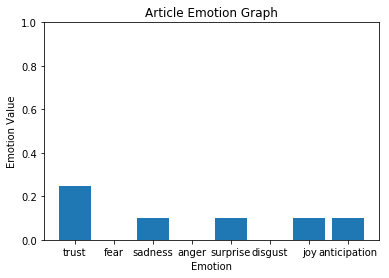

In [215]:
predictEmotion("train_article21.txt")